<!-- Centered layout with a university logo -->
<div align="center">

  <!-- University Logo -->
  <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <!-- Assignment Title -->
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">Deep Reinforcement Learning</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Assignment 06 - Multi-Armed and Contextual Bandits</h2>

  <!-- Department and University -->
  <h3 style="color:#696880; font-size: 24px; margin-top: 20px;">Computer Engineering Department</h3>
  <h3 style="color:#696880; font-size: 22px; margin-top: -5px;">Sharif University of Technology</h3>

  <!-- Semester -->
  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">Spring 2025</h3>

  <!-- Authors -->
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Full name: Ashkan Majidi</h3>
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Student ID: 400109984</h3>

  <!-- Horizontal Line for Separation -->
  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


## Setup & Overview  
In this notebook, we simulate bandit problems using *MAB* (Multi-Armed Bandit) and *CtxBnd* (Contextual Bandit) frameworks.  
We compare several agents:
- **Oracle** (with privileged info)
- **RndAg** (Random Agent)
- **ExpFstAg** (Explore-First Agent)
- **UCB_Ag** (UCB Agent)
- **EpsGdAg** (Epsilon-Greedy Agent)
- **LinUCB_Ag** (LinUCB for contextual bandits)


Follow the instructions carefully and complete the sections marked with **TODO**.

## Setup and Environment

In the upcoming cells, we import necessary libraries, set up utility functions for reproducibility and plotting, and define the basic components of our bandit experiments.


In [12]:
# %% [code]
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dataclasses import dataclass
from copy import deepcopy
from tqdm.notebook import tqdm

plt.rcParams['figure.dpi'] = 100

In [13]:
# %% [code]
def plot_logs(df, x_key, y_key, legend_key, **kwargs):
    num = len(df[legend_key].unique())
    pal = sns.color_palette("hls", num)
    if 'palette' not in kwargs:
        kwargs['palette'] = pal
    ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
    return ax

def set_seed(s):
    np.random.seed(s)
    random.seed(s)

set_seed(0)

## MAB Overview  
We consider a bandit with 10 arms. Two formulations:  
- **Stochastic:** Each arm gives a reward of 1 with probability *p*.  
- **Deterministic:** Each arm always returns a fixed reward.  
  
We'll work with the stochastic case. The reward probabilities will be set randomly.

In [14]:
# %% [code]
nArms = 10
p_arr = [np.random.random() for _ in range(nArms)]
print("Probabilities:", p_arr)

Probabilities: [0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


**Q:** How might the performance of different agents change if the distribution of probabilities were not uniform?  

**A:**  If the distribution of probabilities is not uniform, agents that rely on exploration (e.g., UCB, Epsilon-Greedy) may take longer to identify the best arm, especially if the best arm has a much higher probability than others. Random agents will perform poorly as they cannot exploit the skewed distribution. Algorithms like LinUCB, which leverage additional context, may perform better in identifying the best arm in such scenarios.

In [15]:
# %% [code]
@dataclass
class MAB_Env:
    p_arr: np.ndarray

    def step(self, act):
        return 1 if np.random.random() < self.p_arr[act] else 0

**Q:** Why does the MAB environment use a simple binary reward mechanism (1 or 0)?

**A:** The MAB environment uses a binary reward mechanism because it simplifies the problem and aligns with many real-world scenarios where outcomes are binary (e.g., success/failure, click/no-click). This approach makes it easier to model and analyze the performance of different algorithms while focusing on the exploration–exploitation trade-off.

In [16]:
# %% [code]
@dataclass
class MAB_Eng:
    p_arr: np.ndarray
    max_steps: int
    agent: any

    def __post_init__(self):
        self.env = MAB_Env(p_arr=self.p_arr)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_acts = []
            self.agent.reset()
            for t in range(self.max_steps):
                act = self.agent.get_action()
                rew = self.env.step(act)
                self.agent.update_Q(act, rew)
                run_acts.append(act)
                run_rewards.append(rew)
            logs.append(pd.DataFrame({
                'reward': run_rewards,
                'action': run_acts,
                'step': np.arange(len(run_rewards))
            }))
        return pd.concat(logs, ignore_index=True)

In [17]:
# %% [code]
def mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500):
    all_logs = []
    for idx, agent in enumerate(tqdm(agents, desc="Alg Sweeps")):
        engine = MAB_Eng(p_arr=p_arr, max_steps=max_steps, agent=agent)
        log_df = engine.run(n_runs)
        log_df['Alg'] = labels[idx]
        all_logs.append(log_df)
    return pd.concat(all_logs, ignore_index=True)

## Oracle Agent  
The **Oracle** has full knowledge of *p_arr*.  
**Question:** What is the maximum expected per-step reward?

In [18]:
# TODO: Compute oracleReward using privileged info (simple placeholder)
oracleReward = max(p_arr)  # Placeholder
print(f'Max possible reward (Simple): {oracleReward}')

Max possible reward (Simple): 0.9636627605010293


**Q:** What insight does the oracle reward give us about the best possible performance?

**A:** The oracle reward represents the theoretical upper bound on the performance of any agent in the environment. It provides a benchmark to evaluate the efficiency of other algorithms and highlights the maximum achievable reward under ideal conditions.

-------------------

**Q:** Why is the oracle considered “cheating” in a practical sense?

**A:** The oracle is considered “cheating” because it has access to privileged information (e.g., the exact probabilities of rewards for each arm) that is not available to real-world agents. In practical scenarios, agents must learn these probabilities through exploration, making the oracle an unrealistic baseline.

## RndAg (Random Agent)  
This agent selects an action at random at every timestep. It does no learning.


In [19]:
@dataclass
class RndAg:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        pass  # No learning

    def get_action(self):
        self.t += 1
        # TODO: get a random action index [Simple]
        sel_act = 0  # Placeholder
        return sel_act

In [20]:
# %% [code]
rnd_agent = RndAg(n_act=len(p_arr))
n_runs = 1000
rnd_log = mab_swp([rnd_agent], p_arr, ['Rnd'], n_runs=n_runs)

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

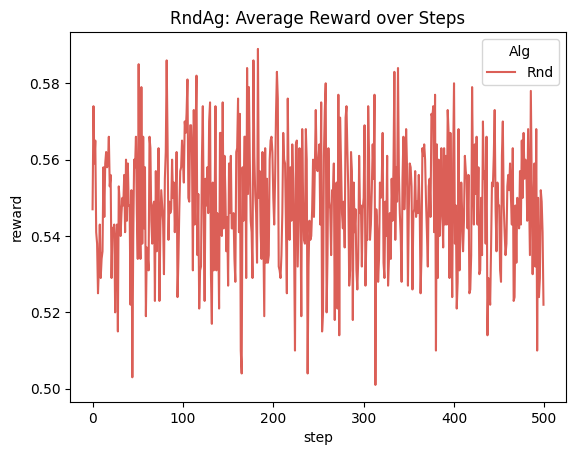

In [10]:
# %% [code]
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
plt.title("RndAg: Average Reward over Steps")
plt.show()

**Q:** Why is the reward of the random agent generally lower and highly variable?  

**A:** The random agent selects actions uniformly at random without any consideration of the reward probabilities of the arms.

------------

**Q:** How might you improve a random agent without using any learning mechanism?  

**A:** You could improve a random agent by introducing a weighted random selection mechanism, where arms with higher historical rewards are given higher probabilities of being selected. Alternatively, you could use a heuristic-based approach, such as prioritizing arms with higher initial probabilities (if known) or periodically re-evaluating arm selection probabilities based on observed outcomes.

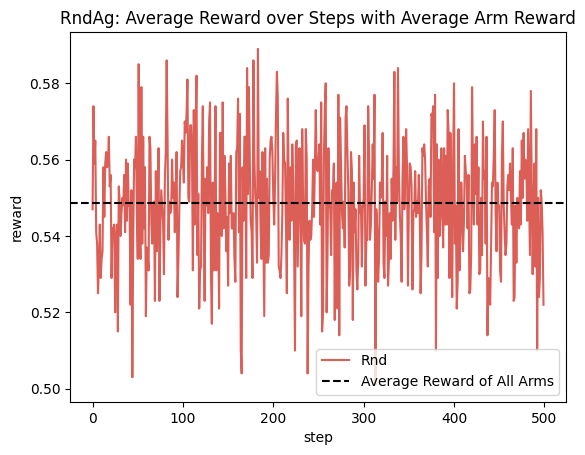

In [11]:
# TODO: Plot RndAg reward curve and average reward of all arms (Simple)
# Calculate the average reward of all arms
avg_reward = np.mean(rnd_log["reward"])

# Plot RndAg reward curve
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
plt.axhline(y=avg_reward, color='black', linestyle='--', label='Average Reward of All Arms')
plt.legend()
plt.title("RndAg: Average Reward over Steps with Average Arm Reward")
plt.show()

**Analysis:**  
- The x-axis shows the number of steps; y-axis shows average reward.  
- Regret is the gap between Oracle and agent performance.

## ExpFstAg (Explore-First Agent)  
This agent explores randomly for the first *max_ex* steps, then exploits the best arm thereafter.

In [21]:
@dataclass
class ExpFstAg:
    n_act: int
    max_ex: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # TODO: update Q value (Simple placeholder)
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        # TODO: Choose random action for t <= max_ex, else best arm [Simple]
        if self.t <= self.max_ex:
            sel_act = np.random.randint(0, self.n_act)
        else:
            sel_act = np.argmax(self.Q)
        return sel_act

### Run ExpFstAg with max_ex = 5  
We will test ExpFstAg (with 5 exploration steps) over 1000 runs and 500 steps.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

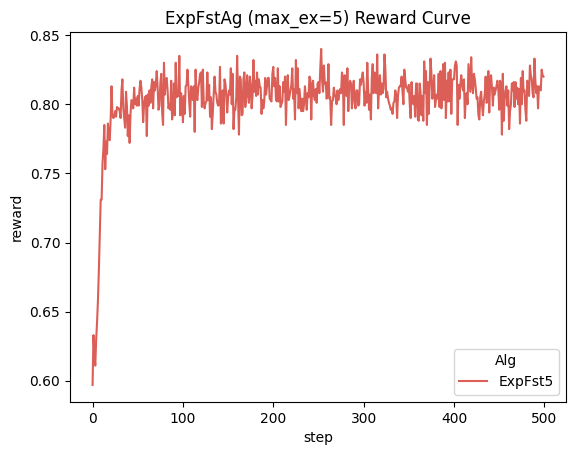

In [22]:
# %% [code]
max_ex = 5
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)
expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{max_ex}'], n_runs=1000, max_steps=500)
plot_logs(expfst_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
plt.title(f"ExpFstAg (max_ex={max_ex}) Reward Curve")
plt.show()

**Analysis:**  
- The ExpFstAg should outperform RndAg by identifying the best arm during exploration.  
- However, with too short exploration, it may miss the best arm.

----------

**Q:** Why might the early exploration phase (e.g., 5 steps) lead to high fluctuations in the reward curve?  

**A:** The early exploration phase involves selecting actions randomly, which can lead to inconsistent rewards due to the stochastic nature of the environment. If the best arm is not sampled during this phase, the agent may fail to identify it, resulting in high variability in the reward curve.

------------  
**Q:** What are the trade-offs of using a fixed exploration phase?  

**A:** A fixed exploration phase ensures that the agent gathers sufficient data to estimate the rewards of different arms. However, if the phase is too short, the agent may not explore enough to identify the best arm. Conversely, if it is too long, the agent delays exploitation, potentially missing out on higher cumulative rewards. Balancing exploration and exploitation is critical to optimizing performance.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

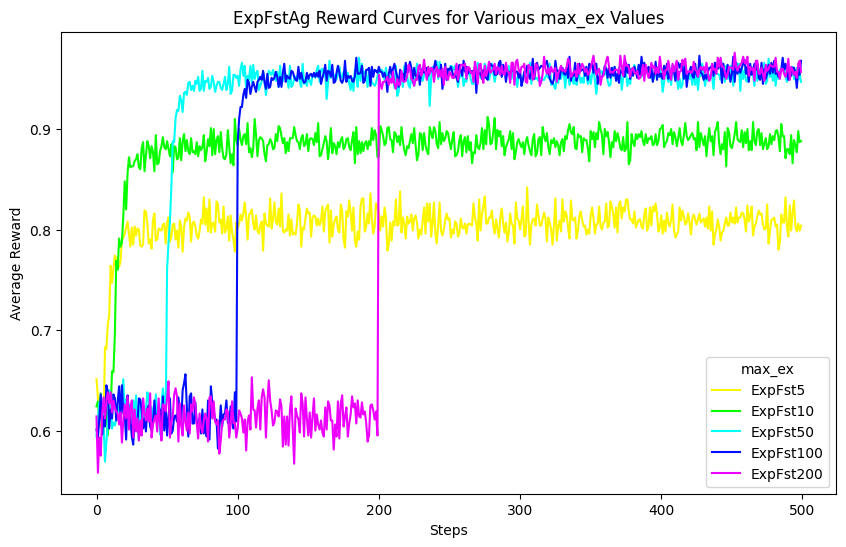

In [23]:
# TODO: Run ExpFstAg for various max_ex values: [5, 10, 50, 100, 200] (Simple placeholder)
plt.figure(figsize=(10, 6))  # Set the figure size

# Generate a color palette with as many colors as the number of experiments
colors = sns.color_palette("hsv", len([5, 10, 50, 100, 200]))

for idx, ex in enumerate([5, 10, 50, 100, 200]):
    expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=ex)
    expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{ex}'], n_runs=1000, max_steps=500)
    sns.lineplot(
        data=expfst_log,
        x='step',
        y='reward',
        label=f'ExpFst{ex}',  # Add label for legend
        color=colors[idx],    # Assign a unique color to each plot
        estimator='mean',
        errorbar=None
    )

plt.title("ExpFstAg Reward Curves for Various max_ex Values")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(title="max_ex")  # Add legend with title
plt.show()

**Observations:**  
- Short exploration (e.g., 5 or 10 steps) may not reliably find the best arm.  
- Longer exploration (e.g., 50 or 100 steps) improves performance but may delay exploitation.

**Q:** How does increasing `max_ex` affect the convergence of the agent’s performance?

**A:** Increasing `max_ex` allows the agent to explore more arms before committing to exploitation. This can improve the accuracy of identifying the best arm, leading to better long-term performance. However, it delays the exploitation phase, which may result in lower cumulative rewards in the short term. The trade-off is between gathering sufficient information and starting exploitation early enough to maximize rewards.

Additionally, note that if max_ex is more than a number (for example 50 in our experiment) the reward wont change much if we increase the max_ex

------------------------------

**Q:** In real-world scenarios, what challenges might arise in selecting the optimal exploration duration?

**A:** In real-world scenarios, the optimal exploration duration depends on factors like the variability of rewards, the number of arms, and the time horizon of the task. Challenges include:
- **Finite time horizon:** Over-exploration can waste valuable time that could be spent exploiting the best arm.
- **Dynamic environments:** If the reward probabilities change over time, a fixed exploration duration may become suboptimal.


## UCB_Ag (UCB Agent)  
UCB dynamically balances exploration and exploitation by adding an exploration bonus to Q-values.

In [24]:
@dataclass
class UCB_Ag:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # TODO: Update Q value (Simple placeholder)
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        delta = 1e-5  # to avoid division by zero
        # TODO: Compute exploration bonus (Simple placeholder)
        bonus = np.sqrt(2 * np.log(self.t + delta) / (self.act_counts + delta))
        Q_explore = self.Q + bonus
        sel_act = np.random.choice(np.flatnonzero(Q_explore == Q_explore.max()))
        return sel_act

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

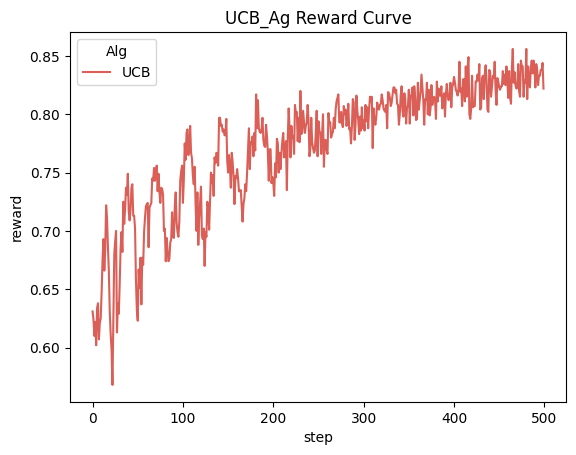

In [25]:
# %% [code]
ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=500)
plot_logs(ucb_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
plt.title("UCB_Ag Reward Curve")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** An explore-first strategy might outperform UCB in scenarios with a finite time horizon where early exploitation is critical. For example:
- **Short-term tasks:** If the time horizon is small, UCB’s conservative exploration may delay exploitation, leading to suboptimal cumulative rewards.
- **Low variance environments:** In environments where the reward probabilities are close to deterministic, explore-first strategies can quickly identify the best arm and exploit it effectively.

-----------------

**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:**
- **Explore-First Strategy:** Performs well in short-term scenarios if the exploration phase is appropriately tuned. However, it may fail in long-term scenarios if the exploration phase is too short to identify the best arm.
- **UCB:** Balances exploration and exploitation dynamically, making it optimal in long-term scenarios. However, its conservative exploration bonus can lead to slower convergence in short-term tasks.
- **Epsilon-Greedy:** The choice of ε affects performance. A high ε favors exploration, which is beneficial in long-term scenarios but reduces short-term rewards. A low ε favors exploitation, which is better for short-term tasks but risks missing the best arm.

## UCB vs. ExpFstAg  
Now we compare UCB_Ag and ExpFstAg (with max_ex = 5) side by side.


**Question:**  
Why does UCB learn slowly (even after 500 steps, not reaching maximum reward)?  
*Hint:* Consider the conservative nature of the exploration bonus.


Running comparison (Simple)...


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

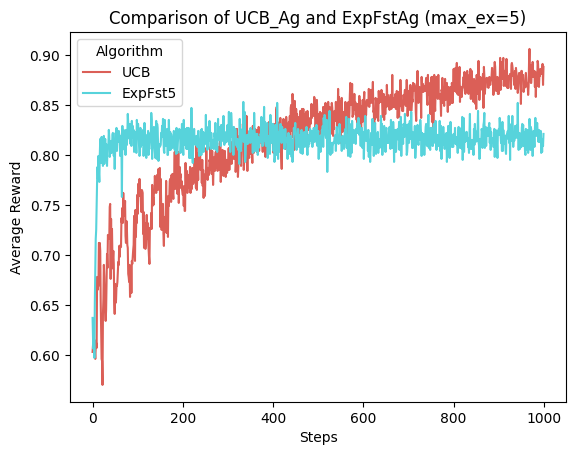

In [26]:
# TODO: Run UCB_Ag and ExpFstAg (max_ex=5) for 1000 runs, 1000 steps (Simple placeholder)
print("Running comparison (Simple)...")

# Initialize agents
ucb_agent = UCB_Ag(n_act=len(p_arr))
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=5)

# Run experiments
comparison_logs = mab_swp(
    agents=[ucb_agent, expfst_agent],
    p_arr=p_arr,
    labels=["UCB", "ExpFst5"],
    n_runs=1000,
    max_steps=1000
)

# Plot results
plot_logs(comparison_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
plt.title("Comparison of UCB_Ag and ExpFstAg (max_ex=5)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(title="Algorithm")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** repeated question.

---------------

**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** repeated question.

**Question:**  
What happens if we let ExpFstAg explore for 20 steps? Compare its reward to UCB.

Running comparison (Simple)...


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

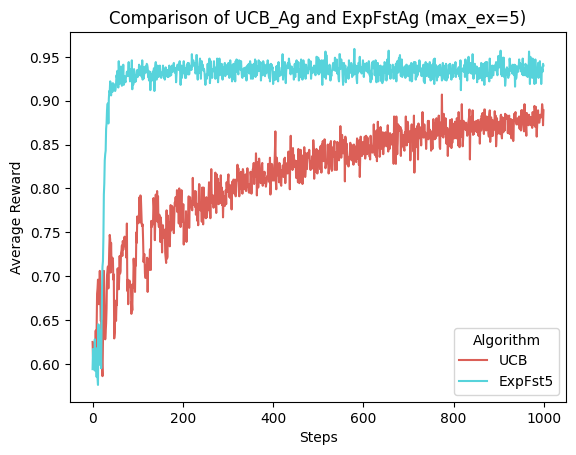

In [27]:
# TODO: Run UCB_Ag and ExpFstAg (max_ex=5) for 1000 runs, 1000 steps (Simple placeholder)
print("Running comparison (Simple)...")

# Initialize agents
ucb_agent = UCB_Ag(n_act=len(p_arr))
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=20)

# Run experiments
comparison_logs = mab_swp(
    agents=[ucb_agent, expfst_agent],
    p_arr=p_arr,
    labels=["UCB", "ExpFst5"],
    n_runs=1000,
    max_steps=1000
)

# Plot results
plot_logs(comparison_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
plt.title("Comparison of UCB_Ag and ExpFstAg (max_ex=5)")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(title="Algorithm")
plt.show()

**Q:** What impact does increasing the exploration phase to 20 steps have compared to 5 steps?

**A:** Increasing the exploration phase to 20 steps allows the agent to gather more information about the reward probabilities of each arm, improving the likelihood of identifying the best arm‌ And as you see it outperforms ExpFstAg.

---------------

**Q:** How can you determine the optimal balance between exploration and exploitation in practice?

**A:** In Explore-First Agent (not generally just and just for our case) a prior knoledge of environment is cruical. for example of we know our max timesteps we can set max_ex to be a division of that. If we can run multiple times and use hyperparameter tunning it could be an approch to find best number of exploration steps.

**Q:** We know that UCB is optimal. Why might ExpFstAg perform better in practice?  

**A:** ExpFstAg can perform better in practice under finite-time scenarios because it allows for early exploitation after a fixed exploration phase. This can lead to higher cumulative rewards in the short term, especially when the exploration phase is well-tuned to the environment. Hyperparameter tuning (e.g., setting `max_ex` appropriately) can help ExpFstAg quickly identify the best arm and exploit it, avoiding the conservative exploration of UCB, which may delay exploitation. Additionally, in environments with low variance or a clear gap between the best and other arms, ExpFstAg's simpler strategy can yield better practical performance compared to UCB's more cautious approach.

## Skewed Arms Scenario  
We now consider a skewed probability distribution where one arm is significantly better.

Running skewed arms experiment... (Simple)


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

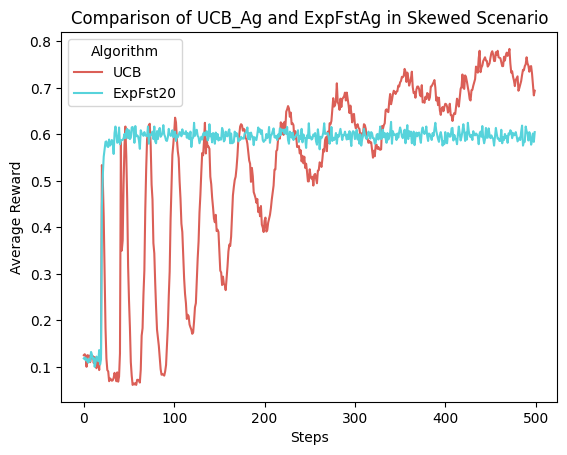

In [28]:
skewed_p = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07,
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
# TODO: Compare UCB_Ag and ExpFstAg (max_ex=len(skewed_p)) in skewed scenario (Simple placeholder)
print("Running skewed arms experiment... (Simple)")

# Initialize agents
ucb_agent = UCB_Ag(n_act=len(skewed_p))
expfst_agent = ExpFstAg(n_act=len(skewed_p), max_ex=len(skewed_p))

# Run experiments
skewed_logs = mab_swp(
    agents=[ucb_agent, expfst_agent],
    p_arr=skewed_p,
    labels=["UCB", f"ExpFst{len(skewed_p)}"],
    n_runs=1000,
    max_steps=500
)

# Plot results
plot_logs(skewed_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', errorbar=None)
plt.title("Comparison of UCB_Ag and ExpFstAg in Skewed Scenario")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(title="Algorithm")
plt.show()

**Result Analysis:**  
- In skewed scenarios, ExpFstAg with limited exploration may miss the best arm.  
- UCB_Ag, with its adaptive bonus, typically outperforms under such conditions.

## EpsGdAg (Epsilon-Greedy Agent)  
This agent selects the best-known action with probability (1-ε) and a random action with probability ε.

In [29]:
@dataclass
class EpsGdAg:
    n_act: int
    eps: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        # TODO: Choose random action with probability eps [Simple]
        if np.random.random() < self.eps:
            sel_act = np.random.randint(0, self.n_act)  # Random action
        else:
            sel_act = np.argmax(self.Q)  # Exploit best-known action
        return sel_act

**Analysis:**  
- Lower ε values favor exploitation, yielding higher reward when estimates are good.  
- Higher ε increases exploration but reduces immediate reward.  
- One strategy: decay ε over time (e.g., ε = ε₀ / t) or switch to ε = 0 after a burn-in period.

-----------

**Q:** Why does a high ε value result in lower immediate rewards?  

**A:** A high ε value increases the probability of selecting a random action, which means the agent is more likely to choose suboptimal arms instead of exploiting the best-known arm. This leads to lower immediate rewards as the agent sacrifices exploitation for exploration.

----------

**Q:** What benefits might there be in decaying ε over time?

**A:** Decaying ε over time allows the agent to explore more in the early stages when it has limited knowledge about the environment and gradually shift toward exploitation as it gains confidence in its reward estimates. This balances the exploration–exploitation trade-off, improving long-term performance by reducing unnecessary exploration in later stages.


Running EpsGdAg experiments with various eps values... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

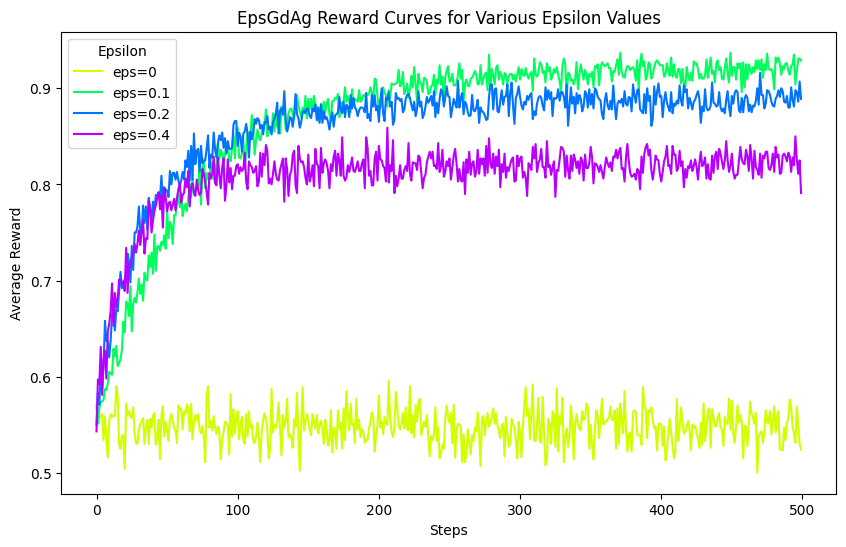

In [30]:
# TODO: Plot reward curves for EpsGdAg with epsilons [0, 0.1, 0.2, 0.4] (Simple placeholder)
print("Running EpsGdAg experiments with various eps values... (Simple)")

epsilons = [0, 0.1, 0.2, 0.4]
plt.figure(figsize=(10, 6))  # Set the figure size

# Generate a color palette for the plots
colors = sns.color_palette("hsv", len(epsilons))

for idx, eps in enumerate(epsilons):
    eps_gd_agent = EpsGdAg(n_act=len(p_arr), eps=eps)
    eps_gd_log = mab_swp([eps_gd_agent], p_arr, [f'EpsGd (eps={eps})'], n_runs=1000, max_steps=500)
    sns.lineplot(
        data=eps_gd_log,
        x='step',
        y='reward',
        label=f'eps={eps}',  # Add label for legend
        color=colors[idx],   # Assign a unique color to each plot
        estimator='mean',
        errorbar=None
    )

plt.title("EpsGdAg Reward Curves for Various Epsilon Values")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.legend(title="Epsilon")
plt.show()

**Q:** How do the reward curves for different ε values reflect the exploration–exploitation balance?  

**A:** The reward curves for different ε values show how the agent balances exploration and exploitation. A higher ε results in more exploration and help the agent discover better arms in the long run. Conversely, a lower ε favors exploitation, leading to higher immediate rewards but risking suboptimal performance if the agent prematurely commits to a suboptimal arm. As you see more

------------------

**Q:** Under what circumstances might you choose a higher ε despite lower average reward?

**A:** A higher ε might be chosen in scenarios where exploration is critical, such as:
- **Dynamic environments:** Where reward probabilities change over time, requiring continuous exploration to adapt.
- **High uncertainty:** When the agent has limited prior knowledge about the environment and needs to explore more to gather sufficient information.
- **Short-term tasks with high variance:** To ensure the agent samples enough arms to avoid missing potentially high-reward arms.

## Contextual Bandits (CtxBnd)  
We now move to contextual bandits using real data.  
Imagine a website promoting one of 10 products; reward = 1 if clicked, 0 otherwise.  
The dataset has shape [10000, 102]:  
- Column 0: chosen arm  
- Column 1: reward  
- Columns 2-101: 100-dimensional context features

In [58]:
# %% [code]
# Download the dataset (if not already downloaded)
!wget -q http://www.cs.columbia.edu/~jebara/6998/dataset.txt -O dataset.txt

# !curl -s -o dataset.txt http://www.cs.columbia.edu/~jebara/6998/dataset.txt

In [59]:
# TODO: Load dataset.txt into a numpy array of shape [10000, 102] (Simple placeholder)
# import pandas as pd

# try:
#     # Use pandas to load the dataset and handle potential formatting issues
#     ctxData = pd.read_csv("dataset.txt", header=None, sep=' ').to_numpy()
#     print("Dataset loaded (Simple version):", ctxData.shape)
# except Exception as e:
#     print("Error loading dataset:", e)


ctxData = np.loadtxt("dataset.txt")
print("Dataset loaded (Simple version):", ctxData.shape)

Dataset loaded (Simple version): (10000, 102)


In [60]:
ctxData

array([[ 2.,  0.,  5., ..., 30.,  4.,  0.],
       [ 8.,  0.,  1., ...,  0.,  0., 10.],
       [ 5.,  0.,  3., ...,  3.,  0.,  0.],
       ...,
       [ 9.,  1., 79., ...,  0.,  0.,  0.],
       [ 4.,  0., 29., ..., 17.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0., 12.]])

In [61]:
# tmp = [ ctxData[i, :-1] for i in range(ctxData.shape[0])]
# tmp = np.array(tmp, dtype=int)
# ctxData = tmp
# ctxData

In [69]:
# %% [code]
@dataclass
class CtxBnd_Env:
    data: any
    t: int = 0

    def step(self, act):
        if act == self.data[self.t, 0]:
            rew = self.data[self.t, 1]
        else:
            rew = None
        self.t += 1
        return rew

    def reset(self):
        self.t = 0

## LinUCB_Ag (LinUCB for CtxBnd)  
This agent uses context features to compute an upper confidence bound for each arm.

In [102]:
@dataclass
class LinUCB_Ag:
    n_act: int
    alpha: float
    feat_dim: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.As = [np.eye(self.feat_dim) for _ in range(self.n_act)]  # Identity matrix for each arm
        self.bs = [np.zeros((self.feat_dim, 1)) for _ in range(self.n_act)]  # Zero vector for each arm

    def get_ucb(self, a, state):
        # TODO: Compute UCB for arm a given state (Simple placeholder)
        A_inv = np.linalg.inv(self.As[a])  # Inverse of A for arm a
        theta = A_inv @ self.bs[a]  # Estimate of theta for arm a
        state = np.array(state).reshape(-1, 1)  # Ensure state is a column vector
        p = (theta.T @ state).item() + self.alpha * np.sqrt((state.T @ A_inv @ state).item())  # UCB score
        return p

    def update_params(self, a, rew, state):
        if rew is None:
            return
        # TODO: Update A and b for arm a (Simple placeholder)
        state = np.array(state).reshape(-1, 1)  # Ensure state is a column vector
        self.As[a] += state @ state.T  # Update A for arm a
        self.bs[a] += rew * state  # Update b for arm a

    def get_action(self, state):
        # TODO: Compute UCB estimates for all arms (Simple placeholder)
        p_est = [self.get_ucb(a, state) for a in range(self.n_act)]  # Compute UCB for all arms
        # TODO: Choose arm with highest UCB (Simple placeholder)
        p_est = np.array(p_est)
        maxes = p_est == p_est.max()
        nonzero = np.flatnonzero(maxes)
        sel_act = np.random.choice(nonzero)
        return sel_act

**Q:** How does LinUCB leverage context to outperform classical bandit algorithms?  

**A:** LinUCB leverages context by incorporating additional features (contextual information) to estimate the reward for each arm. Unlike classical bandit algorithms, which rely solely on past rewards, LinUCB assumes a linear relationship between the context and the reward. This allows it to generalize across similar contexts, enabling better decision-making even with limited data. By using context, LinUCB can identify patterns and exploit them to select the best arm more effectively, especially in environments where the reward depends on external factors.

------------------

**Q:** What is the role of the α parameter in LinUCB, and how does it affect the exploration bonus?

**A:** The α parameter in LinUCB controls the exploration bonus added to the estimated reward for each arm. A higher α increases the exploration bonus, encouraging the agent to explore less frequently chosen arms. This helps the agent gather more information about uncertain arms. Conversely, a lower α reduces the exploration bonus, leading to more exploitation of the best-known arm. The choice of α balances the trade-off between exploration and exploitation, with higher values favoring exploration and lower values favoring exploitation.

In [103]:
# %% [code]
@dataclass
class CtxBnd_Eng:
    data: any
    agent: any

    def __post_init__(self):
        self.env = CtxBnd_Env(data=self.data)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='CtxRuns'):
            aligned_ctr = []
            ret_val = 0
            valid_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.data.shape[0]), desc='Time'):
                state = self.data[t, 2:]
                act = self.agent.get_action(state=state)
                rew = self.env.step(act)
                self.agent.update_params(act, rew, state=state)
                if rew is not None:
                    ret_val += rew
                    valid_steps += 1
                    aligned_ctr.append(ret_val / float(valid_steps))
            logs.append(pd.DataFrame({'aligned_ctr': aligned_ctr, 'step': np.arange(len(aligned_ctr))}))
        return pd.concat(logs, ignore_index=True)

In [104]:
# %% [code]
def ctxBnd_swp(alphas, data, n_runs=2000):
    logs = []
    for alpha in tqdm(alphas, desc="Alpha Sweeps"):
        agent = LinUCB_Ag(n_act=10, feat_dim=100, alpha=alpha)
        eng = CtxBnd_Eng(data=data, agent=agent)
        log_df = eng.run(n_runs)
        log_df['alpha'] = alpha
        logs.append(log_df)
    return pd.concat(logs, ignore_index=True)


In [112]:
# TODO: Run ctxBnd_swp with alphas = [0, 0.01, 0.1, 0.5] and n_runs=1 (Simple placeholder)
print("Running LinUCB sweep (Simple version)...")

alphas = [0, 0.01, 0.1, 0.5]
logs_ctx = ctxBnd_swp(alphas=alphas, data=ctxData, n_runs=4)

print("LinUCB sweep completed. Logs shape:", logs_ctx.shape)

Running LinUCB sweep (Simple version)...


Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/4 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/4 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/4 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/4 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

LinUCB sweep completed. Logs shape: (4950, 3)


In [114]:
# logs_ctx[logs_ctx["alpha"] == 0.01]

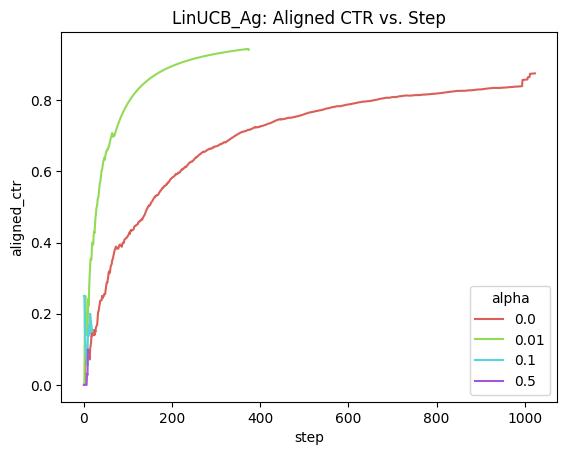

In [113]:
# %% [code]
plot_logs(logs_ctx, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', errorbar=None)
plt.title("LinUCB_Ag: Aligned CTR vs. Step")
plt.show()

**Q:** What does **α** affect in LinUCB?  

**A:** The **α** parameter in LinUCB controls the exploration bonus added to the estimated reward for each arm. A higher **α** encourages more exploration by increasing the confidence interval, making the agent more likely to try arms with higher uncertainty. Conversely, a lower **α** reduces the exploration bonus, leading to more exploitation of the best-known arms. The value of **α** directly affects the balance between exploration and exploitation.

------------------

**Q:** Do the reward curves change with **α**? Explain why or why not.

**A:** Yes, the reward curves change with **α**. A higher **α** results in more exploration, which can lead to slower convergence and lower immediate rewards but may improve long-term performance by identifying the best arm more reliably. A lower **α** leads to faster exploitation, resulting in higher immediate rewards but risks missing the best arm if the agent does not explore enough. The shape of the reward curve reflects how the agent balances exploration and exploitation based on the value of **α**.

**Q:** Based on your experiments, does LinUCB outperform the standard UCB algorithm? Why or why not?

**A:** LinUCB can outperform the standard UCB algorithm in scenarios where the reward depends on contextual features. By leveraging context, LinUCB can make more informed decisions, especially in environments where the relationship between context and reward is linear or approximately linear. However, in non-contextual or low-dimensional settings, LinUCB may not provide significant advantages and could even underperform due to the overhead of maintaining and updating additional parameters. The performance depends on the quality of the context and the linearity of the reward model.

------------------

**Q:** What are the key limitations of each algorithm, and how would you choose between them for a given application?

**A:**
- **UCB:**
  - **Limitations:** Assumes stationarity and does not leverage contextual information. It may explore too conservatively in finite-horizon scenarios, leading to slower convergence.
  - **When to Use:** Suitable for non-contextual bandit problems with stationary reward distributions and when computational simplicity is desired.

- **LinUCB:**
  - **Limitations:** Assumes a linear relationship between context and reward, which may not hold in complex environments. It can overfit in high-dimensional or noisy contexts and has higher computational overhead.
  - **When to Use:** Ideal for contextual bandit problems where the reward depends on features and the relationship is approximately linear. Use when context is informative and computational resources are sufficient.

- **Choosing Between Them:**
  - Use UCB for simpler, non-contextual problems or when computational efficiency is critical.
  - Use LinUCB for problems with rich contextual information and when the relationship between context and reward is expected to be linear or close to linear.

# Some final question
## Finite‑Horizon Regret and Asymptotic Guarantees:
Question:
Many algorithms (e.g., UCB) are analyzed using asymptotic (long‑term) regret bounds. In a finite‑horizon scenario (say, 500–1000 steps), explain intuitively why an algorithm that is asymptotically optimal may still yield poor performance. What trade‑offs arise between aggressive early exploration and cautious long‑term learning?
Deep Dive:
Discuss how the exploration bonus, tuned for asymptotic behavior, might delay exploitation in finite time, leading to high early regret despite eventual convergence.


## Hyperparameter Sensitivity and Exploration–Exploitation Balance:
Question:
Consider the impact of hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB. Explain intuitively how slight mismatches in these parameters can lead to either under‑exploration (missing the best arm) or over‑exploration (wasting pulls on suboptimal arms). How would you design a self‑adaptive mechanism to balance this trade‑off in practice?
Deep Dive:
Provide insight into the “fragility” of these parameters in finite runs and how a meta‑algorithm might monitor performance indicators (e.g., variance in rewards) to adjust its exploration dynamically.


## Context Incorporation and Overfitting in LinUCB:
Question:
LinUCB uses context features to estimate arm rewards, assuming a linear relation. Intuitively, why might this linear assumption hurt performance when the true relationship is complex or when the context is high‑dimensional and noisy? Under what conditions can adding context lead to worse performance than classical (context‑free) UCB?
Deep Dive:
Discuss the risk of overfitting to noisy or irrelevant features, the curse of dimensionality, and possible mitigation strategies (e.g., dimensionality reduction or regularization).

## Adaptive Strategy Selection:
Question:
Imagine designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB based on observed performance. What signals (e.g., variance of reward estimates, stabilization of Q‑values, or sudden drops in reward) might indicate that a switch is warranted? Provide an intuitive justification for how and why such a meta‑strategy might outperform either strategy alone in a finite‑time setting.
Deep Dive:
Explain the challenges in detecting when exploration is “enough” and how early exploitation might capture transient improvements even if the long‑term guarantee favors UCB.


## Non‑Stationarity and “Forgetting” Mechanisms:
Question:
In non‑stationary environments where reward probabilities drift or change abruptly, standard bandit algorithms struggle because they assume stationarity. Intuitively, explain how and why a “forgetting” or discounting mechanism might improve performance. What challenges arise in choosing the right decay rate, and how might it interact with the exploration bonus?
Deep Dive:
Describe the delicate balance between retaining useful historical information and quickly adapting to new trends, and the potential for “chasing noise” if the decay is too aggressive.

## Exploration Bonus Calibration in UCB:
Question:
The UCB algorithm adds a bonus term that decreases with the number of times an arm is pulled. Intuitively, why might a “conservative” (i.e., high) bonus slow down learning—even if it guarantees asymptotic optimality? Under what circumstances might a less conservative bonus be beneficial, and what risks does it carry?
Deep Dive:
Analyze how a high bonus may force the algorithm to continue sampling even when an arm’s estimated reward is clearly suboptimal, thereby delaying convergence. Conversely, discuss the risk of prematurely discarding an arm if the bonus is too low.


## Exploration Phase Duration in Explore‑First Strategies:
Question:
In the Explore‑First agent (ExpFstAg), how does the choice of a fixed exploration period (e.g., 5 vs. 20 steps) affect the regret and performance variability? Provide a scenario in which a short exploration phase might yield unexpectedly high regret, and another scenario where a longer phase might delay exploitation unnecessarily.
Deep Dive:
Discuss how the “optimal” exploration duration can depend heavily on the underlying reward distribution’s variance and the gap between the best and other arms, and why a one‑size‑fits‑all approach may not work in practice.


## Bayesian vs. Frequentist Approaches in MAB:
Question:
Compare the intuition behind Bayesian approaches (such as Thompson Sampling) to frequentist methods (like UCB) in handling uncertainty. Under what conditions might the Bayesian approach yield superior practical performance, and how do the underlying assumptions about prior knowledge influence the exploration–exploitation balance?
Deep Dive:
Explore the benefits of incorporating prior beliefs and the risk of bias if the prior is mis-specified, as well as how Bayesian updating naturally adjusts the exploration bonus as more data is collected.


## Impact of Skewed Reward Distributions:
Question:
In environments where one arm is significantly better (skewed probabilities), explain intuitively why agents like UCB or ExpFstAg might still struggle to consistently identify and exploit that arm. What role does variance play in these algorithms, and how might the skew exacerbate errors in reward estimation?
Deep Dive:
Discuss how the variability of rare but high rewards can mislead the agent’s estimates and cause prolonged exploration of suboptimal arms.


##Designing for High-Dimensional, Sparse Contexts:
Question:
In contextual bandits where the context is high-dimensional but only a few features are informative, what are the intuitive challenges that arise in using a linear model like LinUCB? How might techniques such as feature selection, regularization, or non-linear function approximation help, and what are the trade-offs involved?
Deep Dive:
Provide insights into the risks of overfitting versus underfitting, the increased variance in estimates from high-dimensional spaces, and the potential computational costs versus performance gains when moving from a simple linear model to a more complex one.

### Finite‑Horizon Regret and Asymptotic Guarantees:
**Answer:**  
In finite-horizon scenarios, asymptotically optimal algorithms like UCB may perform poorly because they prioritize long-term learning over short-term gains. The exploration bonus in UCB is designed to ensure that all arms are sufficiently explored, which can delay exploitation of the best arm. This leads to high early regret, as the algorithm continues to sample suboptimal arms even when the best arm is evident. The trade-off lies in balancing aggressive early exploration (to gather information) with cautious long-term learning (to minimize regret over time).

**Deep Dive:**  
The exploration bonus in UCB, tuned for asymptotic behavior, may cause the algorithm to over-explore in finite time, leading to suboptimal performance. In contrast, strategies that exploit earlier (e.g., explore-first) may achieve better short-term rewards but risk missing the best arm in the long run.

---

### Hyperparameter Sensitivity and Exploration–Exploitation Balance:
**Answer:**  
Hyperparameters like ε in ε-greedy, the exploration constant in UCB, and α in LinUCB directly control the balance between exploration and exploitation. Slight mismatches can lead to under-exploration (missing the best arm) or over-exploration (wasting resources on suboptimal arms). A self-adaptive mechanism could monitor performance indicators like reward variance or convergence of Q-values to dynamically adjust these parameters.

**Deep Dive:**  
Hyperparameters are fragile in finite runs because they are often tuned for specific environments. A meta-algorithm could dynamically adjust exploration based on observed metrics, such as increasing exploration when variance in rewards is high or reducing it when Q-values stabilize.

---

### Context Incorporation and Overfitting in LinUCB:
**Answer:**  
The linear assumption in LinUCB can hurt performance when the true relationship between context and reward is complex or when the context is high-dimensional and noisy. Adding context can lead to worse performance than classical UCB if the context introduces irrelevant or noisy features, leading to overfitting.

**Deep Dive:**  
High-dimensional contexts increase the risk of overfitting and the curse of dimensionality. Mitigation strategies include dimensionality reduction (e.g., PCA), regularization (e.g., L2 penalty), or switching to non-linear models like neural networks. However, these approaches trade off computational efficiency for improved accuracy.

---

### Adaptive Strategy Selection:
**Answer:**  
A hybrid agent could switch between explore-first and UCB based on signals like reward variance, stabilization of Q-values, or sudden drops in reward. For example, high variance in rewards might indicate the need for more exploration, while stable Q-values suggest it is time to exploit.

**Deep Dive:**  
Detecting when exploration is “enough” is challenging because it depends on the environment's dynamics. Early exploitation might capture transient improvements, but it risks missing long-term gains. A meta-strategy could outperform by dynamically balancing exploration and exploitation based on observed performance.

---

### Non‑Stationarity and “Forgetting” Mechanisms:
**Answer:**  
In non-stationary environments, a forgetting mechanism (e.g., exponential decay) helps the agent adapt to changes by giving more weight to recent observations. However, choosing the right decay rate is critical: too aggressive a decay may cause the agent to chase noise, while too slow a decay may prevent adaptation.

**Deep Dive:**  
The balance between retaining historical information and adapting to new trends is delicate. Forgetting mechanisms must be tuned to the rate of change in the environment. Combining decay with adaptive exploration bonuses can improve performance in dynamic settings.

---

### Exploration Bonus Calibration in UCB:
**Answer:**  
A conservative (high) exploration bonus in UCB slows down learning by forcing the algorithm to sample suboptimal arms excessively, delaying convergence. A less conservative bonus can speed up learning but risks prematurely discarding arms that might be optimal.

**Deep Dive:**  
High bonuses ensure asymptotic optimality but lead to high early regret. Conversely, low bonuses may cause the algorithm to exploit too early, missing the best arm. The challenge lies in calibrating the bonus to balance exploration and exploitation effectively.

---

### Exploration Phase Duration in Explore‑First Strategies:
**Answer:**  
A short exploration phase may yield high regret if the agent fails to identify the best arm, especially in environments with high variance. A longer phase may delay exploitation unnecessarily, reducing cumulative rewards.

**Deep Dive:**  
The optimal exploration duration depends on the reward distribution's variance and the gap between the best and other arms. A one-size-fits-all approach is ineffective; adaptive strategies that adjust exploration duration based on observed performance are more robust.

---

### Bayesian vs. Frequentist Approaches in MAB:
**Answer:**  
Bayesian approaches like Thompson Sampling incorporate prior beliefs and update them as data is collected, naturally balancing exploration and exploitation. They often outperform frequentist methods like UCB in environments with well-specified priors or high uncertainty.

**Deep Dive:**  
Bayesian methods adapt exploration bonuses dynamically based on posterior distributions, while frequentist methods rely on fixed rules. However, Bayesian approaches are sensitive to mis-specified priors, which can bias results. Frequentist methods are more robust in such cases but may require more exploration.

---

### Impact of Skewed Reward Distributions:
**Answer:**  
In skewed environments, agents like UCB or ExpFstAg may struggle to identify the best arm due to high variance in reward estimates. Rare but high rewards can mislead the agent, causing prolonged exploration of suboptimal arms.

**Deep Dive:**  
Skewed distributions exacerbate errors in reward estimation, as the agent may overestimate the value of arms with occasional high rewards. Strategies that incorporate variance reduction or robust reward estimation can mitigate this issue.

---

### Designing for High-Dimensional, Sparse Contexts:
**Answer:**  
In high-dimensional contexts, LinUCB risks overfitting to noisy or irrelevant features. Techniques like feature selection, regularization, or non-linear models can improve performance but introduce trade-offs in computational cost and interpretability.

**Deep Dive:**  
High-dimensional spaces increase variance in parameter estimates, leading to unstable decisions. Dimensionality reduction (e.g., PCA) reduces noise but may discard useful information. Regularization (e.g., L2 penalty) mitigates overfitting but may underfit sparse contexts. Non-linear models improve accuracy but are computationally expensive and harder to interpret.